In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.metrics import pairwise
from scipy.spatial.distance import hamming
from scipy.stats import entropy, pearsonr
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib
from fuzzywuzzy import fuzz

C:\Users\Mohan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mohan\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#Import training, test
import os
os.chdir('C:/Users/Mohan/Downloads/Quora/')
train = pd.read_csv('train.csv', encoding = "ISO-8859-1")[:10000]
test = pd.read_csv('test.csv',encoding = "ISO-8859-1")[:10000]

C:\Users\Mohan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Prep training, test data 
traindata = []
traindata2 = []
testdata = []
testdata2 = []
for i in range(0,len(train['question1'])):
    traindata.append("".join(train['question1'][i].lower()))
for i in range(0,len(train['question2'])):
    traindata2.append("".join(train['question2'][i].lower()))
for i in range(0,len(test['question1'])):
    testdata.append("".join(test['question1'][i].lower()))
for i in range(0,len(test['question2'])):
    testdata2.append("".join(test['question2'][i].lower()))
train['question1'] = traindata
train['question2']= traindata2
test['question1']=testdata
test['question2']=testdata2

In [5]:
#TDIDF transform the question pairs
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_txt = pd.Series(train['question1'].tolist() + train['question2'].tolist() + test['question1'].tolist() + test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)


<4000x6135 sparse matrix of type '<class 'numpy.float64'>'
	with 20339 stored elements in Compressed Sparse Row format>

In [5]:
#Check how similar the question pairs are
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1), str(st2))
    return seq.ratio()

#Check how many words are shared amongth each question
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

#Feature Engineer
def get_features(df_features):
    #Count number of nouns shared
    print('nouns...')
    df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x))) if t[:1] in ['N']])
    df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x))) if t[:1] in ['N']])
    df_features['feat_nounmatch'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1) 
    
    #Count number of verbs shared
    print('verbs...')
    df_features['question1_verbs'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x))) if t[:1] in ['V']])
    df_features['question2_verbs'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x))) if t[:1] in ['V']])
    df_features['feat_verbmatch'] = df_features.apply(lambda r: sum([1 for w in r.question1_verbs if w in r.question2_verbs]), axis=1) 
    
    #Get string and word length
    print('lengths...')
    df_features['feat_len1'] = df_features.question1.map(lambda x: len(str(x)))
    df_features['feat_len2'] = df_features.question2.map(lambda x: len(str(x)))
    df_features['feat_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    df_features['feat_word_len2'] = df_features.question2.map(lambda x: len(str(x).split()))
    
    #Apply diff_ratio
    print('difflib...')
    df_features['feat_match_ratio'] = df_features.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  
    
    #Apply word match
    print('word match...')
    df_features['feat_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    
    #Apply tdidf
    print('tfidf...')
    df_features['feat_tfidf_sum1'] = df_features.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['feat_tfidf_sum2'] = df_features.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['feat_tfidf_mean1'] = df_features.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df_features['feat_tfidf_mean2'] = df_features.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    
    #Get fuzzy similarities 
    print('fuzzy...')
    df_features['feat_QRatio'] = df_features.apply(lambda x: fuzz.QRatio(str(x.question1), str(x.question2)),axis=1)
    df_features['feat_WRatio'] = df_features.apply(lambda x: fuzz.WRatio(str(x.question1), str(x.question2)),axis=1)
    df_features['feat_PRatio'] = df_features.apply(lambda x: fuzz.partial_ratio(str(x.question1), str(x.question2)), axis=1)
    df_features['feat_PTRatio'] = df_features.apply(lambda x: fuzz.partial_token_set_ratio(str(x.question1), str(x.question2)), axis=1)
    
    #Get different distance metrics of the strings
    print('similary...')
    df_features['feat_tfidf_cos'] = df_features.apply(lambda x: pairwise.cosine_similarity(
        tfidf.transform([str(x.question1)]), tfidf.transform([str(x.question2)]))[0,0], axis=1)
    df_features['feat_tfidf_jac'] = df_features.apply(lambda x: 1 - hamming(
        tfidf.transform([str(x.question1)]).toarray()[0], tfidf.transform([str(x.question2)]).toarray()[0]), axis=1)
    df_features['feat_tfidf_kl'] = df_features.apply(lambda x: entropy(
        tfidf.transform([str(x.question1)]).toarray()[0] + 1e-10, 
        tfidf.transform([str(x.question2)]).toarray()[0]+ 1e-10), axis=1)
    df_features['feat_tfidf_pr'] = df_features.apply(lambda x: pearsonr(
        tfidf.transform([str(x.question1)]).toarray()[0], 
        tfidf.transform([str(x.question2)]).toarray()[0])[0], axis=1)
    return df_features.fillna(0.0)


In [6]:
train = get_features(train)

nouns...
verbs...
lengths...
difflib...
word match...
tfidf...


C:\Users\Mohan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Mohan\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fuzzy...
similary...


C:\Users\Mohan\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\Mohan\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [7]:
col = [c for c in train.columns if c[:4]=='feat']

#Training set and test set is imbalanced, so add more negative sample size to training set to offset
pos_train = train[train['is_duplicate'] == 1]
neg_train = train[train['is_duplicate'] == 0]
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train = pd.concat([pos_train, neg_train])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

0.19107198022860675


In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(train[col], train['is_duplicate'], test_size=0.2, random_state=0)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1666

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=100)
#print(log_loss(train.is_duplicate, bst.predict(xgb.DMatrix(train[col]))))

[0]	train-logloss:0.682997	valid-logloss:0.683069
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.376205	valid-logloss:0.383059
[200]	train-logloss:0.338674	valid-logloss:0.351726
[300]	train-logloss:0.325583	valid-logloss:0.343659
[400]	train-logloss:0.314599	valid-logloss:0.338484


In [ ]:
test = get_features(test)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[col]))

sub.to_csv('qsub1.csv', index=False)

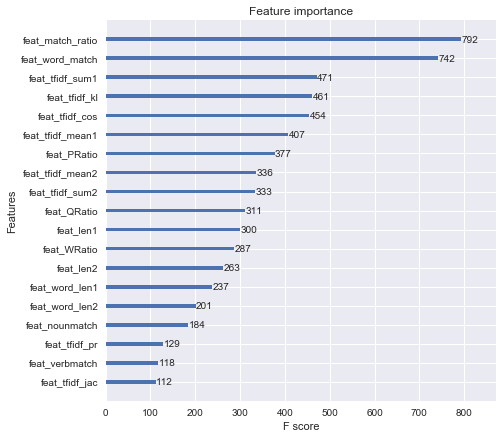

In [9]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(bst); plt.show()